# Training AU visualization model
*written by Eshin Jolly*

To train an AU vizualization model you'll need to extracted labels and landmarks from the EmotioNet, DISFA Plus, and BP4d datasets. Detailed code on how to do that can be found in the [extracting labels and landmarks notebook](https://py-feat.org/content/extract_labels_and_landmarks.html). You'll need to run the extraction once for each dataset before you can train the AU visualization model with the code presented here. 

This tutorial assumes that the extracted csv files are in the `data/extracted_labels_landmarks` folder at the root of this repository. And that files are names as (lowercase) `[dataset]_labels.csv` and `[dataset]_landmarks.csv`

## Imports and Paths

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys, h5py
from feat.utils import registration, neutral, get_resource_path, load_h5
from feat.plotting import predict, plot_face
from sklearn.model_selection import KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn import __version__ as skversion
from joblib import dump
from IPython.core.display import display, HTML
sns.set_style('white')
%matplotlib inline

# Set data directory to data folder relative to location of this notebook
data_dir = os.path.join(os.path.dirname(os.path.dirname(os.path.realpath(""))), "data" , "extracted_labels_landmarks")

# Specify AUs we want to use for training
au_cols = [1, 2, 4, 5, 6, 7, 9, 10, 12, 14, 15, 17, 18, 20, 23, 24, 25, 26, 28, 43]
au_cols = [f"AU{au}" for au in au_cols]
print(f"Using {len(au_cols)} AUs")

/Users/Esh/anaconda3/envs/py-feat/lib/python3.8/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


Using 20 AUs


## Load, clean, and aggregate extracted labels and landmarks

In [6]:
# EmotioNet
labels_emotionet = pd.read_csv(os.path.join(data_dir, "emotionet_labels.csv")).replace(
    {999: np.nan}
)
landmarks_emotionet = pd.read_csv(os.path.join(data_dir, "emotionet_landmarks.csv"))
print("EmotioNet: ", len(labels_emotionet))

# DISFA Plus
labels_disfaplus = pd.read_csv(os.path.join(data_dir, "disfaplus_labels.csv"))
landmarks_disfaplus = pd.read_csv(os.path.join(data_dir, "disfaplus_landmarks.csv"))
# Disfa is rescaled to 0 - 1
disfaplus_aus = [col for col in labels_disfaplus.columns if "AU" in col]
labels_disfaplus[disfaplus_aus] = labels_disfaplus[disfaplus_aus].astype("float") / 5
print("DISFA Plus: ", len(labels_disfaplus))

# BP4d
labels_bp4d = pd.read_csv(os.path.join(data_dir, "bp4d_labels.csv")).replace(
    {9: np.nan}
)
bp4d_pruned_idx = labels_bp4d[au_cols].dropna(axis=1).index
labels_bp4d = labels_bp4d.iloc[bp4d_pruned_idx, :]
landmarks_bp4d = pd.read_csv(os.path.join(data_dir, "bp4d_landmarks.csv")).iloc[
    bp4d_pruned_idx, :
]
print("BP4D: ", len(labels_bp4d))

# Aggregate datasets
labels = pd.concat([labels_emotionet, labels_disfaplus, labels_bp4d]).reset_index(
    drop=True
)
landmarks = pd.concat(
    [landmarks_emotionet, landmarks_disfaplus, landmarks_bp4d]
).reset_index(drop=True)

landmarks = landmarks.iloc[labels.index]
labels = labels[au_cols].fillna(0)

print(f"Aggregated landmarks: {landmarks.shape}")
print(f"Aggregated labels: {labels.shape}")


EmotioNet:  24587
DISFA Plus:  57668
BP4D:  143951
Aggregated landmarks: (226206, 136)
Aggregated labels: (226206, 20)


## Fit PLSRegression model

We train our model using PLSRegression with a minimum of 500 samples for each AU activation. We evaluate the model in a 3-fold split and retrain the model with all the data which is distributed with the package.

In [7]:
min_pos_sample = 500

print('Pseudo balancing samples')
balY = pd.DataFrame()
balX = pd.DataFrame()
for AU in labels[au_cols].columns:
    if np.sum(labels[AU]==1) > min_pos_sample:
        replace = False
    else:
        replace = True
    newSample = labels[labels[AU]>.5].sample(min_pos_sample, replace=replace, random_state=0)
    balX = pd.concat([balX, newSample])
    balY = pd.concat([balY, landmarks.loc[newSample.index]])
X = balX[au_cols].values
y = registration(balY.values, neutral)

# Model Accuracy in KFold CV
print("Evaluating model with KFold CV")
n_components=len(au_cols)
kf = KFold(n_splits=3)
scores = []
for train_index, test_index in kf.split(X):
    X_train,X_test = X[train_index],X[test_index]
    y_train,y_test = y[train_index],y[test_index]
    clf = PLSRegression(n_components=n_components, max_iter=2000)
    _ = clf.fit(X_train,y_train);
    scores.append(clf.score(X_test,y_test))
print('3-fold accuracy mean', np.round(np.mean(scores),2))

# Train real model
clf = PLSRegression(n_components=n_components, max_iter=2000)
_ = clf.fit(X,y)
print('N_comp:',n_components,'Rsquare', np.round(clf.score(X,y),2))

Pseudo balancing samples
Evaluating model with KFold CV
3-fold accuracy mean 0.13
N_comp: 20 Rsquare 0.15


## Saving and loading trained model
We save and package the trained visualization model in two ways:
1. Using `joblib.dump` as recommended by the [sklearn docs](https://scikit-learn.org/stable/modules/model_persistence.html). This is the default model that gets loaded if your installed Python and sklearn `major.minor` versions match those the model was originally trained with
2. As an HDF5 file with the necessary attributes to initialize a new `PLSRegression` object on any system. This is the fallback that gets loaded if your installed Python and sklearn `major.minor` versions don't match what the model was originally trained with

In [89]:
model_name = "pyfeat_aus_to_landmarks"

# Add some extra attributes to the model instance and dump it
clf.X_train = X
clf.Y_train = y
clf.skversion = skversion
clf.pyversion = sys.version
_ = dump(clf, os.path.join(get_resource_path(), f"{model_name}.joblib"))

# Do the same as an hdf5 file
hf = h5py.File(os.path.join(get_resource_path(), f"{model_name}.h5"), "w")
_ = hf.create_dataset("coef", data=clf.coef_)
_ = hf.create_dataset("x_mean", data=clf._x_mean)
_ = hf.create_dataset("x_std", data=clf._x_std)
_ = hf.create_dataset("y_mean", data=clf._y_mean)
_ = hf.create_dataset("x_train", data=clf.X_train)
_ = hf.create_dataset("y_train", data=clf.Y_train)
_ = hf.create_dataset("skversion", data=clf.skversion)
_ = hf.create_dataset("pyversion", data=clf.pyversion)
hf.close()


Now we can use the `load_h5` utility helper function included in the toolbox to try loading our model

In [9]:
loaded_model = load_h5()
np.allclose(loaded_model.coef_, clf.coef_)

True

## Visualize AUs
The regression was trained on labels 0-1 so we do not recommend exceeding 1 for the intensity. Setting the intensity to 2 will exaggerate the face and anything beyond that might give you strange faces. 

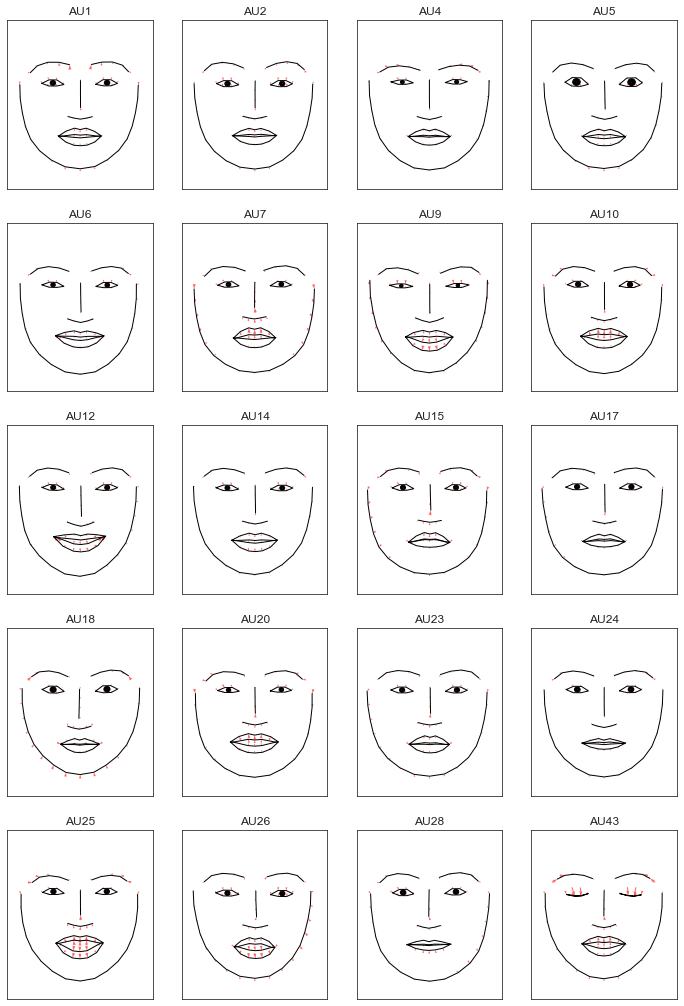

In [54]:
# Exaggerate the intensity of the expression for clearer visualization
# Don't recommend exceeding 2
intensity = 2

def plot_au_intensity(intensity, au_idx, clf, ax):
    # Initialize zero vector of component vals
    au = np.zeros(clf.n_components)
    # Set requested AU intensity
    au[au_idx] = intensity
    # Generate landmark predictions
    predicted = clf.predict([au]).reshape(2, 68)
    # Plot it
    return plot_face(
        au=au,
        model=clf,
        ax=ax,
        vectorfield={
            "reference": neutral.T,
            "target": predicted,
            "color": "r",
            "alpha": 0.6,
        },
    )


# Plot results for each action unit
f, axes = plt.subplots(5, 4, figsize=(12, 18))
axes = axes.flatten()

for aui, axis in enumerate(axes):
    ax = plot_au_intensity(intensity, aui, clf, axis)
    _ = ax.set(title=au_cols[aui])
